# DrawResolution, version 2 for paper


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS

- creation date : May 25th 2020



In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools
import matplotlib.gridspec as gridspec
from matplotlib.patches import Circle,Ellipse

In [47]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (13, 13),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'font.size': 14}
plt.rcParams.update(params)

In [48]:
from scipy.interpolate import interp1d

## Constants for conversions

In [49]:
m_to_mm=1000.
mm_to_m=1e-3
inch_to_mm=25.4
mm_to_inch=1./inch_to_mm
mm_to_micr=1e3
micr_to_m=1e-6
micr_to_mm=1e-3
m_to_micr=1./micr_to_m
m_to_cm=100.
m_to_nm=1e9
nm_to_m=1./m_to_nm
nm_to_micr=0.001

In [50]:
arcdeg_to_arcmin=60.
arcmin_to_arcdeg=1./arcdeg_to_arcmin
arcmin_to_arcsec=60.
arcdeg_to_arcsec=arcdeg_to_arcmin*arcmin_to_arcsec
arcsec_to_arcdeg=1./arcdeg_to_arcsec

In [51]:
deg_to_rad=np.pi/180.

In [52]:
rad_to_deg=1./deg_to_rad
rad_to_arcsec=rad_to_deg*arcdeg_to_arcsec
rad_to_arcmin=rad_to_deg*arcdeg_to_arcmin
arcmin_to_rad=1./rad_to_arcmin

## Configuration parameters at the telescope

#### telescope

In [53]:
Tel_Focal_Length=12.6 # m : Focal length of the telescope
Tel_Diameter=0.9 # m : Diameter of the telescope    
Tel_Fnum=Tel_Focal_Length/Tel_Diameter
plt_scale=206265/(Tel_Focal_Length*m_to_mm)  # arcsec per mm

#### filter

In [54]:
Filt_D=0.05769 # m distance of the filter position wrt CCD plane
Filt_size=3*inch_to_mm

#### CCD detector

In [55]:
Det_xpic=24.0 # microns per pixel
#Det_NbPix=2048 # number of pixels per CCD side
Det_NbPix=2512 # number of pixels per CCD side For 400 only
Det_size=Det_xpic*Det_NbPix*micr_to_mm # CCD size in mm, 5 cm or 2 inch

In [56]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [57]:
def Dispersion(wl,a,D):
    """ 
    Dispersion(wl,a,D) : number of dx per wavelength
    input arguments:
    - wl : wavelength
    - a  : line pitch
    - D  : Distance CCD-Hologram
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx, x in microns and lambdas in microns
    """
    X=D/a*wl/np.sqrt(1-(wl/a)**2)
    return X

In [58]:
def Dispersion_Rate(wl,a,D):
    """
    Dispersion_Rate(wl) : number of dx per wavelength
    input arguments:
    - wl : wavelength
    - a  : line pitch
    - D  : Distance CCD-Hologram
    
    recommended : all input arguments should be expressed in microns.
    
    - output : dx/dlambda, x in microns and lambdas in microns
    
    """
    dxdlambda=D/a*(np.sqrt(1-(wl/a)**2)+ (wl/a)**2)/(1-(wl/a)**2)
    return dxdlambda 

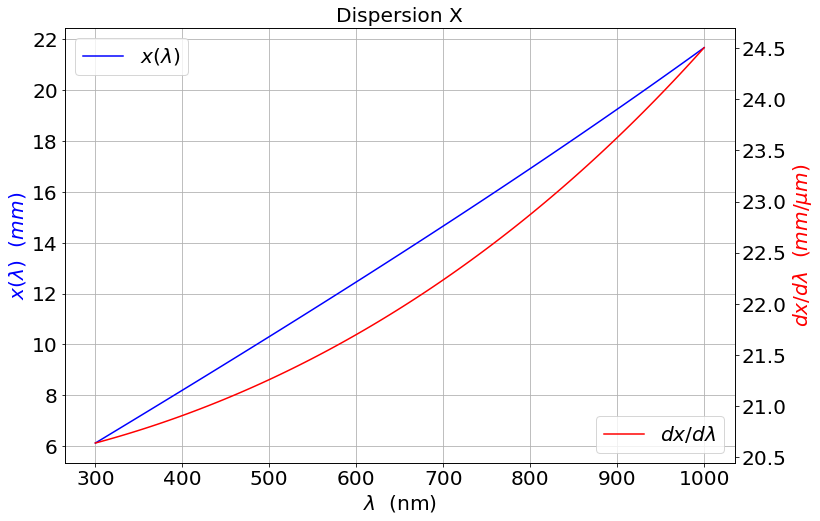

In [59]:
fig, ax1 = plt.subplots(figsize=(12,8))
WL=np.linspace(300.,1000.,100)
a=1/350.*mm_to_micr
D=58*mm_to_micr

Y1=Dispersion(WL*nm_to_micr,a,D)*micr_to_mm
ax1.plot(WL,Y1,"b",label="$x(\lambda)$")

ax1.set_xlabel("$\lambda$  (nm)")
ax1.set_ylabel("$x(\lambda)$  ($mm$)",color="blue")
ax1.set_title("Dispersion X")
ax1.legend(loc="upper left")
ax1.grid()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

Y2=Dispersion_Rate(WL*nm_to_micr,a,D)*micr_to_mm  ## mm per microns
ax2.plot(WL, Y2,"r",label="$dx/d\lambda$")
ax2.set_xlabel("$\lambda$  (nm)")
ax2.set_ylabel("$dx/d\lambda$  ($mm/\mu m$)",color="red")
#ax2.set_title("Dispersion rate")
ax2.legend(loc="lower right")
#ax2.grid()

In [61]:
#WL=np.arange(300,1000,10)
#dXdWL=Dispersion_Rate(WL*1e-3,LINE_PITCH,Z)
#disp_rate_micronspermicrons=Dispersion_Rate(WL_microns,LINE_PITCH,Z)

## Input file

In [62]:
# number of rays
NBEAM_X=11
NBEAM_Y=11
NBEAM=NBEAM_X*NBEAM_Y
NWL=4
NBTOT=NBEAM*NWL

In [63]:
theta_x=0.  # angle in arcmin
theta_y=0.  # angle in arcmin 

In [64]:
theta_x_num=int(theta_x*10)
theta_y_num=int(theta_y*10)

In [65]:
if theta_x_num>0:
    theta_nstr='{:0>2}'.format(theta_x_num)
    theta_x_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_x_num)
    theta_x_str="m"+theta_nstr

In [66]:
if theta_y_num>0:
    theta_nstr='{:0>2}'.format(theta_y_num)
    theta_y_str="p"+theta_nstr
else:
    theta_nstr='{:0>2}'.format(-theta_y_num)
    theta_y_str="m"+theta_nstr

In [67]:
Beam4_Rayfile="Beam4_Rayfile_{:d}_allwl_{}_{}".format(NBTOT,theta_x_str,theta_y_str)

In [68]:
Beam4_Rayfile

'Beam4_Rayfile_484_allwl_m00_m00'

In [69]:
order="OP1"
order_str="+1"

In [70]:
WL=np.array([400.,600.,800.,1000.])

# Read input files

In [71]:
disperser_name=["Ronchi 400","Ronchi 350","Ronchi 300","Ronchi 200","Hologram"]
disperser_color=["k","b","y","g","r"]

In [72]:
infileR400data_excel="R400_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
infileR350data_excel="R350_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
infileR200data_excel="R200_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
infileR300data_excel="R300_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"
infileHOEdata_excel="HOE_PSF_"+ Beam4_Rayfile+"_out_v2.xlsx"

In [73]:
all_files=[infileR400data_excel,infileR350data_excel,infileR300data_excel,infileR200data_excel,infileHOEdata_excel]

In [74]:
all_df=[]
for file in all_files:
    df = pd.read_excel(file,index_col=0)
    all_df.append(df)

In [75]:
df

,xav,xstd,xmin,xmax,xwdt,xfwhm,xrmax,yav,ystd,ymin,ymax,ywdt,yfwhm,yrmax
400nm,8.314969,0.019111,8.27777,8.35273,0.07496,0.054516,0.037761,-1.499144e-19,0.006584,-0.01292,0.01292,0.02584,0.018793,0.01292
600nm,12.635639,0.004811,12.62626,12.64513,0.01887,0.013724,0.009491,1.606225e-20,0.001650,-0.00324,0.00324,0.00648,0.004713,0.00324
800nm,17.167191,0.027634,17.11278,17.22117,0.10839,0.078829,0.054411,-8.566536e-19,0.009384,-0.01842,0.01842,0.03684,0.026793,0.01842
1000nm,22.008016,0.082128,21.84664,22.16877,0.32213,0.234276,0.161376,2.826957e-18,0.027429,-0.05383,0.05383,0.10766,0.078298,0.05383


In [76]:
all_reso= []
for df in all_df:
    all_reso.append(df["xstd"].values)

In [77]:
all_reso

[array([0.04218551, 0.09868684, 0.18637008, 0.3166228 ]),
 array([0.03210489, 0.07427221, 0.13806771, 0.22939021]),
 array([0.02349223, 0.05380075, 0.09868684, 0.16101512]),
 array([0.01046143, 0.02349223, 0.04218551, 0.06702745]),
 array([0.0191112 , 0.00481081, 0.0276341 , 0.08212772])]

# Resolution

## Interpolate

In [78]:
Xint=np.linspace(WL[0],WL[-1],200)

In [79]:
all_Yint_mm=[]
all_Yint_arcsec=[]
for reso in all_reso:
    f = interp1d(WL, reso, kind='cubic')
    Yint=f(Xint)
    all_Yint_mm.append(Yint)
    all_Yint_arcsec.append(Yint*plt_scale)

## Plot 

In [80]:
# Tableau Colors from the 'T10' categorical palette (the default color cycle): 
#{'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 
#'tab:cyan'} (case-insensitive);

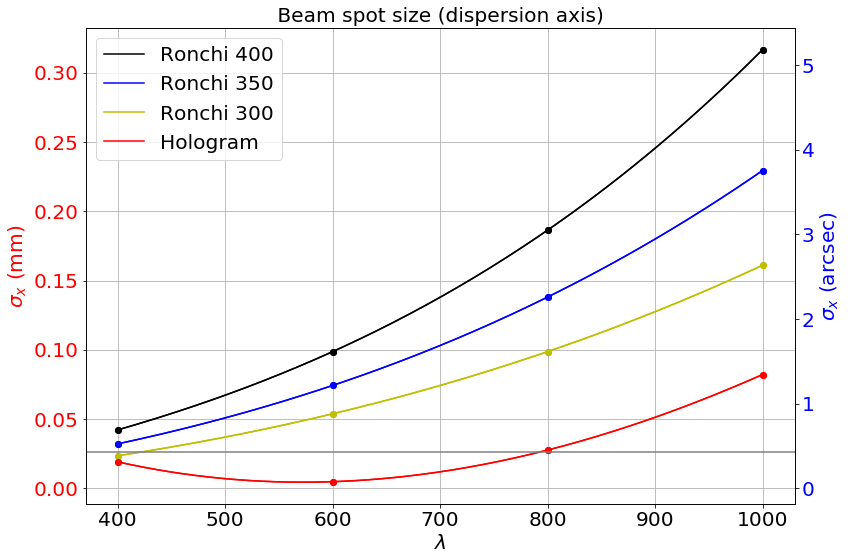

In [81]:

fig, ax1 = plt.subplots(figsize=(12,8))

#color = 'tab:red'
color = 'red'

idx=0
for Yint in all_Yint_mm: 
    if idx==3:  # skip R200
        idx+=1
        continue
    ax1.plot(WL,all_reso[idx],"o",color=disperser_color[idx])
    ax1.plot(Xint,Yint,'-',label=disperser_name[idx],color=disperser_color[idx])
    idx+=1

ax1.set_title(" Beam spot size (dispersion axis) ")
ax1.set_xlabel("$\lambda$")
ax1.set_ylabel("$\sigma_x$ (mm)",color=color)
ax1.grid()
ax1.legend()
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
color = 'blue'
idx=0
for Yint in all_Yint_arcsec: 
    if idx==3:  # skip R200
        idx+=1
        continue
    ax2.plot(WL,all_reso[idx]*plt_scale,"o",color=disperser_color[idx])
    ax2.plot(Xint,Yint,'-',label=disperser_name[idx],color=disperser_color[idx])
    idx+=1

ax2.axhline(y=1./2.36,color="grey")  

ax2.set_ylabel('$\sigma_x$ (arcsec)', color=color)  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("RESOLUTION_PSF_CTIO_v2.pdf")
plt.show()



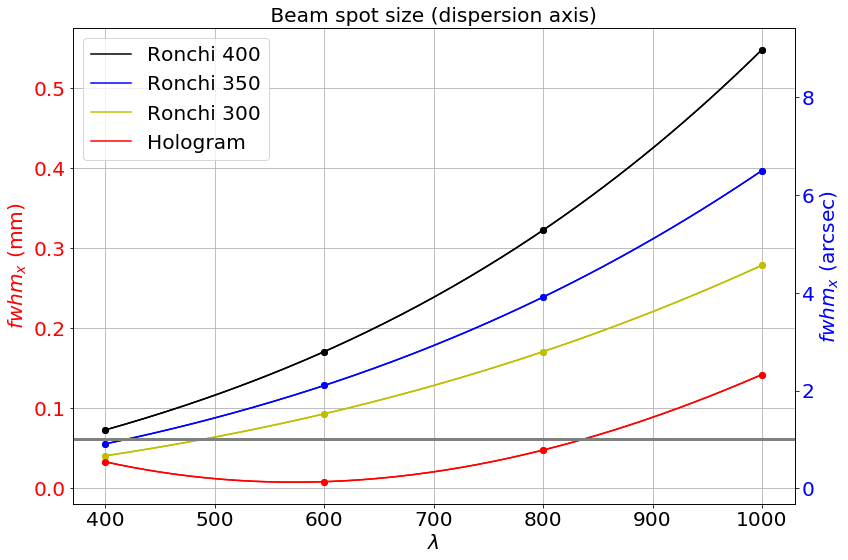

In [82]:
fig, ax1 = plt.subplots(figsize=(12,8))

#color = 'tab:red'
color = 'red'

idx=0
for Yint in all_Yint_mm: 
    if idx==3:  # skip R200
        idx+=1
        continue
    ax1.plot(WL,all_reso[idx]*np.sqrt(3),"o",color=disperser_color[idx])
    ax1.plot(Xint,Yint*np.sqrt(3),'-',label=disperser_name[idx],color=disperser_color[idx])
    idx+=1

ax1.set_title(" Beam spot size (dispersion axis) ")
ax1.set_xlabel("$\lambda$")
ax1.set_ylabel("$fwhm_x$ (mm)",color=color)
ax1.grid()
ax1.legend()
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

#color = 'tab:blue'
color = 'blue'
idx=0
for Yint in all_Yint_arcsec: 
    if idx==3:  # skip R200
        idx+=1
        continue
    ax2.plot(WL,all_reso[idx]*plt_scale*np.sqrt(3),"o",color=disperser_color[idx])
    ax2.plot(Xint,Yint*np.sqrt(3),'-',label=disperser_name[idx],color=disperser_color[idx])
    idx+=1

ax2.axhline(y=1.,color="grey",lw=3)  

ax2.set_ylabel('$fwhm_x$ (arcsec)', color=color)  # we already handled the x-label with ax1
#ax2.plot(t, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("RESOLUTION_PSF_FWHM_CTIO_v2.pdf")
plt.show()




In [83]:
idx=find_nearest_idx(Xint,750)

In [84]:
Yint[idx]

0.3062322349313502

In [85]:
Yint[idx]*16.4/1000

0.005022208652874143

In [86]:
idx=find_nearest_idx(Xint,1000)

In [87]:
Yint[idx]

1.3444502540916463

In [88]:
Yint[idx]*16.4/1000

0.022048984167103

## $R(\lambda)$

In [89]:
#WL

In [90]:
#Xint

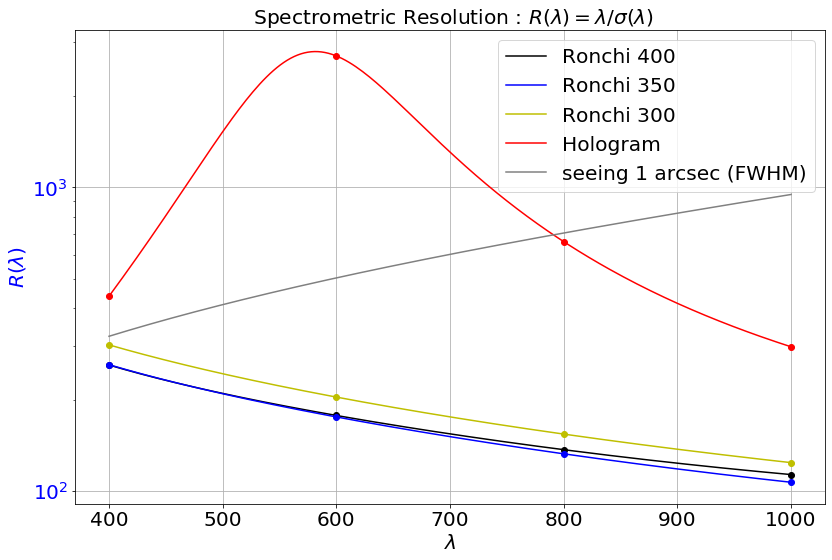

In [91]:
fig, ax1 = plt.subplots(figsize=(12,8))

SEEING_ARCSEC=1.0/2.36  # arcsec
SEEING_MM=SEEING_ARCSEC/plt_scale # sigma Seeing in mm

color = 'blue'
idx=0
for Yint in all_Yint_mm: 
    if idx==0:
        a=1./450.
    elif idx==1:
        a=1./350.
    elif idx==2:
        a=1./300.
    elif idx==3:
        a=1./200.
    else:
        a=1./350.
        
    if idx==3:  # skip R200
        idx+=1
        continue
        
    Y1=WL*micr_to_mm/all_reso[idx]*Dispersion_Rate(WL*nm_to_micr,a*mm_to_micr,D=58*mm_to_micr)*micr_to_mm
    Y2=Xint*micr_to_mm/Yint*Dispersion_Rate(Xint*nm_to_micr,a*mm_to_micr,D=58*mm_to_micr)*micr_to_mm
    ax1.plot(WL,Y1,"o",color=disperser_color[idx])
    ax1.plot(Xint,Y2,'-',label=disperser_name[idx],color=disperser_color[idx])
    idx+=1
    
# seeing
Y3=Xint*micr_to_mm/SEEING_MM*Dispersion_Rate(Xint*nm_to_micr,1./350.*mm_to_micr,D=58*mm_to_micr)*micr_to_mm
ax1.plot(Xint,Y3,'-',label="seeing 1 arcsec (FWHM)",color="grey")
        
ax1.set_title(" Spectrometric Resolution : $R(\lambda)= \lambda/\sigma(\lambda)$")
ax1.set_xlabel("$\lambda$")
ax1.set_ylabel("$R(\\lambda)$",color=color)
ax1.grid()
ax1.legend()
ax1.tick_params(axis='y', labelcolor=color)



fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig("RLAMBDA_PSF_CTIO_v2.pdf")
plt.yscale("log")
plt.show()


